##  Idris Khattak

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# MNIST IMAGE to TENSORS
transform = transforms.ToTensor()

# Downloading and loading the Data

In [5]:
train_data = datasets.MNIST(root='../Data',train=True,download=True,transform=transform)

In [6]:
# We are gonna assign train=False becasue we want to access test data
test_data = datasets.MNIST(root='../Data',train=False,download=True,transform=transform)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [10]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

This is the image of digit 5.
Lets visualize it.

In [11]:
Image,label = train_data[0]

In [12]:
Image.shape

torch.Size([1, 28, 28])

In [13]:
label

5

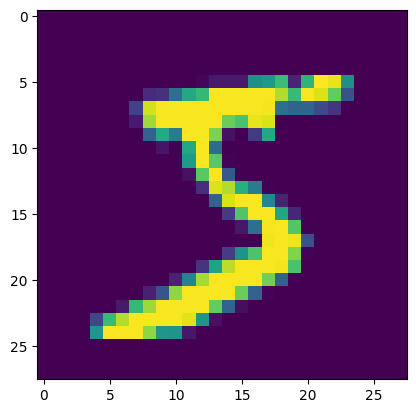

In [14]:
plt.imshow(Image.reshape((28,28)))

This is definitely a grey scale image but matplotlib assign color for color-blind-people

In [15]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size= 100, shuffle=True)

test_loader = DataLoader(test_data, batch_size= 500, shuffle=False)

In [16]:
# First Batch
for images,labels in train_loader:
    break

In [17]:
images.shape

torch.Size([100, 1, 28, 28])

# lets create our model class

In [18]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz = 784, out_sz = 10, layers = [120,84]):
        super().__init__()

        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [19]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Lets see how many parameters does we have in this ANN because later on we are gonna be using this same datasets but we will be using CNN

In [20]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


105,214 parameters means 105,214 connections between the neurons

In [21]:
# Now lets define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

Now lets flaten our images

In [22]:
images.shape

torch.Size([100, 1, 28, 28])

In [23]:
images.view(100,-1).shape

torch.Size([100, 784])

# Training and Evaluation of our model

In [24]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.23562379  accuracy:  83.245%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.35328561  accuracy:  87.532%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.13676533  accuracy:  89.578%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.24926896  accuracy:  94.845%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.14819084  accuracy:  95.078%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.07590230  accuracy:  95.360%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.08559082  accuracy:  96.525%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.06195208  accuracy:  96.627%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.06262500  accuracy:  96.710%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.11283537  accuracy:  97.670%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.05235627  accuracy:  97.498%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.03327996  accuracy:  97.515%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.11384610  accuracy:  98.125%
epoch:  4  b

In [26]:
torch.save(model.state_dict(),'MNIST with ANN.pt')

In [27]:
model.load_state_dict(torch.load('MNIST with ANN.pt'))

<All keys matched successfully>

In [28]:
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)